# Imports

In [1]:
import pyxdf
import pandas as pd
import numpy as np
from glob import glob
import datetime
import matplotlib.pyplot as plt
import sys
import os
# Add the parent directory to the path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("utils"), '..')))
from utils import *

# Load Data

In [2]:
sub_files = glob('/Users/camilla.strauss/Desktop/CUNY_Data/Data/*/*.xdf')

In [ ]:
# Load data for each participant
all_data = {}
for sub_number in range(len(sub_files)): 
    xdf_path = sub_files[sub_number]
    data, header = pyxdf.load_xdf(xdf_path)
    all_data[sub_number] = data


In [4]:
# make df for each modality
all_et_dfs = {}
all_mic_dfs = {}
all_stim_dfs = {}
all_physio_dfs = {}
all_video_dfs = {}
all_eeg_dfs = {}

sub_names = {}

for sub_number in range(len(sub_files)): 
    xdf_path = sub_files[sub_number]
    sub_names[sub_number] = xdf_path.split('/')[6].split('-')[1]

    # ET data
    et_df = import_et_data(xdf_path)
    et_df['diff'] = et_df['lsl_time_stamp'].diff()
    all_et_dfs[sub_number] = et_df

    # stim
    stim_df = import_stim_data(xdf_path)
    stim_df['diff'] = stim_df['lsl_time_stamp'].diff()
    all_stim_dfs[sub_number] = stim_df

    # mic
    mic_df = import_mic_data(xdf_path)
    mic_df['diff'] = mic_df['lsl_time_stamp'].diff()
    all_mic_dfs[sub_number] = mic_df

    # video
    video_df = import_video_data(xdf_path)
    video_df['diff'] = video_df['lsl_time_stamp'].diff()
    all_video_dfs[sub_number] = video_df


    # eeg
    eeg_df = import_eeg_data(xdf_path)
    eeg_df['diff'] = eeg_df['lsl_time_stamp'].diff()
    all_eeg_dfs[sub_number] = eeg_df

    # physio
    physio_df = import_physio_data(xdf_path)
    physio_df['diff'] = physio_df['lsl_time_stamp'].diff()
    all_physio_dfs[sub_number] = physio_df
    
    

: 

# Data Loss Graphs

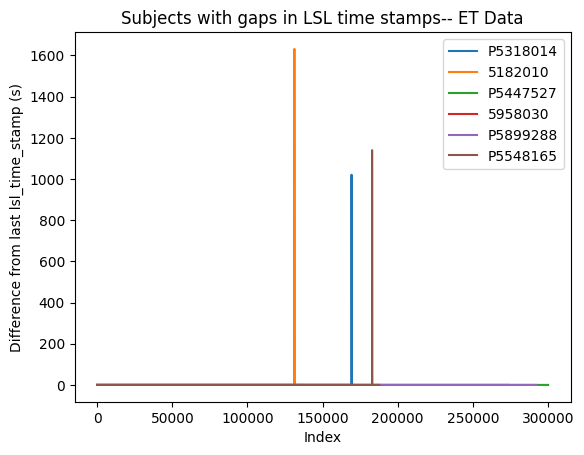

In [152]:
for sub_number in range(len(sub_files)):
    plt.plot(all_et_dfs[sub_number]['diff'], label = sub_names[sub_number])
    plt.ylabel('Difference from last lsl_time_stamp (s)')
    plt.xlabel('Index')

plt.title("Subjects with gaps in LSL time stamps-- ET Data")
plt.legend()
plt.show()

# LSL_time_stamp plots

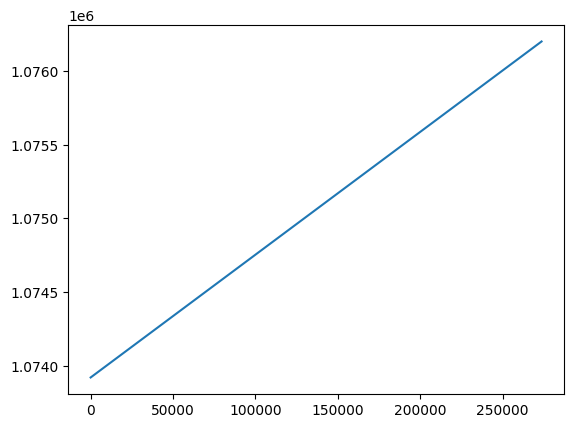

In [ ]:
plt.plot(all_et_dfs[3]['lsl_time_stamp'], label = sub_names[sub_number])

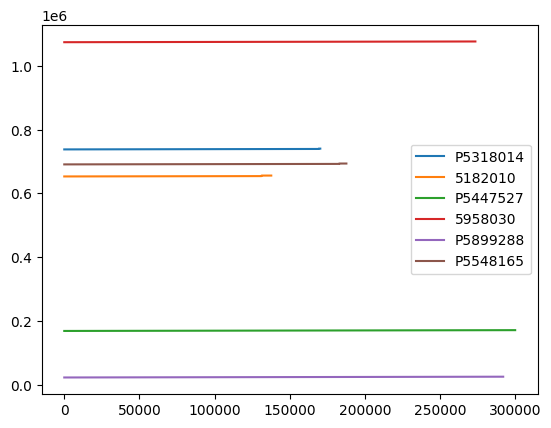

In [ ]:
# plotting them together doesnt work bc different axes
# for sub_number in range(len(sub_files)):
#     plt.plot(all_et_dfs[sub_number]['lsl_time_stamp'], label = sub_names[sub_number])

# plt.legend()


# Percentage of missing data 

In [56]:
# df with percent loss for each sub, each modality
modalities = ['et', 'physio', 'mic', 'video', 'eeg']
percent_list = []

for sub_number in range(len(sub_files)):
    timestamp = int(all_stim_dfs[sub_number].loc[all_stim_dfs[sub_number]['event'] == 'psychopy_time_stamp', 'trigger'].iloc[0])
    date_object = datetime.datetime.fromtimestamp(timestamp)
    date_string = date_object.strftime("%Y-%m-%d")
    
    for modality in modalities:
        df = globals()['all_'+modality+'_dfs'][sub_number]
        subject = sub_names[sub_number]
        
        # median diff between lsl_time_stamp (with 1.05 margin) 
        median1 = df['diff'].median() * 1.05
        # number of loss instances  
        loss_instances = (df['diff'] > median1).sum()
        if loss_instances != 0:
            # amount of data skipped: values for which diff>median 
            amt_data_lost = df.loc[df['diff'] > median1, 'diff'].values[0].sum()
            # total amount of data: last - first lsl_time_stamp
            amt_data_total = df['lsl_time_stamp'].values[-1] - df['lsl_time_stamp'].values[0]

            percent_lost = round(amt_data_lost/amt_data_total * 100, 3)
        else:
            percent_lost = 0
        percent_list.append({'sub_num':sub_number, 'date': date_string, 'subject': subject, 'modality': modality, 'num_losses': loss_instances, 'percent_lost': percent_lost})
        
percent_data_loss = pd.DataFrame(percent_list)

In [57]:
percent_data_loss.sort_values(by='date', inplace=True, ascending=True)
percent_data_loss


,sub_num,date,subject,modality,num_losses,percent_lost
39,7,2024-10-08,P5548165,eeg,0,0.000
37,7,2024-10-08,P5548165,mic,0,0.000
36,7,2024-10-08,P5548165,physio,3,1.379
35,7,2024-10-08,P5548165,et,1,42.149
38,7,2024-10-08,P5548165,video,1,1.739
5,1,2024-10-16,5182010,et,1,58.696
6,1,2024-10-16,5182010,physio,1,0.478
7,1,2024-10-16,5182010,mic,0,0.000
8,1,2024-10-16,5182010,video,1,2.174
9,1,2024-10-16,5182010,eeg,0,0.000


In [58]:
nonzero_loss = percent_data_loss[percent_data_loss['percent_lost'] != 0]
nonzero_loss

,sub_num,date,subject,modality,num_losses,percent_lost
36,7,2024-10-08,P5548165,physio,3,1.379
35,7,2024-10-08,P5548165,et,1,42.149
38,7,2024-10-08,P5548165,video,1,1.739
5,1,2024-10-16,5182010,et,1,58.696
6,1,2024-10-16,5182010,physio,1,0.478
8,1,2024-10-16,5182010,video,1,2.174
0,0,2024-10-17,P5318014,et,1,41.820
11,2,2025-02-17,P5287460,physio,1,1.033
